In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [3]:
import os 

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


In [4]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

time_period = 33
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

In [5]:
import skimage

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}
count_model = 0 

for idx,m in enumerate(list(dic_ssp585.keys())):
    if len(dic_ssp585[m].keys()) > 3 and (count_model < 20):
        count_model += 1
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]

In [6]:
nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    
        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

In [7]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    y_tmp = np.zeros((len(dic_reduced_ssp585[m].keys()),time_period, lat_size*lon_size))
    
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        y_tmp[idx_i,:,:] = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[idx_i,:,nan_idx] = float('nan')
           
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = y_tmp[idx_i,:,:] - mean_ref_ensemble

/tmp/ipykernel_30947/2788081108.py:17: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
/tmp/ipykernel_30947/2788081108.py:19: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())


In [8]:
# compute the forced response
dic_forced_response_ssp585 = dict({})
dic_forced_response_ssp585_tmp = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_spatial_ensemble = y_tmp/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += y_tmp/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):              
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)

/tmp/ipykernel_30947/852978578.py:19: RuntimeWarning: Mean of empty slice
  dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble,axis=0)


In [9]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        x_predictor[m][i] = dic_processed_ssp585[m][i]
        x_predictor[m][i][:,nan_idx] = float('nan')

        y_forced_response[m][i] = dic_forced_response_ssp585[m][i]
        y_forced_response[m][i][:,nan_idx] = float('nan')

In [10]:
# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(x_predictor.keys()):
    variance_processed_ssp585[m] = {}
    arr_tmp = np.zeros((len(x_predictor[m].keys()),time_period,lon_size*lat_size))
    
    for idx_i, i in enumerate(list(x_predictor[m].keys())):
        arr_tmp[idx_i,:,:] = x_predictor[m][i]

    # compute mean across the runs in each grid cell 
    arr_tmp_mean = np.mean(arr_tmp,axis=0)

    # comute the variance value 
    arr_tmp_values = np.zeros((len(x_predictor[m].keys()),time_period,lon_size*lat_size))
    for idx_i, i in enumerate(x_predictor[m].keys()):
        arr_tmp_values[idx_i,:,:] = (x_predictor[m][i] - arr_tmp_mean)**2

    # variance is defines for each grid cell
    variance_processed_ssp585[m] = np.mean(arr_tmp_values,axis=0)

In [11]:
y_forced_response_concatenate = {}
x_predictor_concatenate = {}
var_concatenate = {}
count_x = 0


for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response_concatenate[m] = 0
    x_predictor_concatenate[m] = 0
    var_concatenate[m] = 0

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        count_x += len(dic_processed_ssp585[m].keys())*33
        
        if idx_i ==0:
            y_forced_response_concatenate[m] = dic_forced_response_ssp585[m][i]
            x_predictor_concatenate[m] = dic_processed_ssp585[m][i]
            var_concatenate[m] = variance_processed_ssp585[m]
        else:
            y_forced_response_concatenate[m] = np.concatenate([y_forced_response_concatenate[m],dic_forced_response_ssp585[m][i]])
            x_predictor_concatenate[m] = np.concatenate([x_predictor_concatenate[m], dic_processed_ssp585[m][i]],axis=0)  
            var_concatenate[m] = np.concatenate([var_concatenate[m], variance_processed_ssp585[m]],axis=0)

    var_concatenate[m][:,nan_idx] = float('nan')
    x_predictor_concatenate[m][:,nan_idx] = float('nan')
    y_forced_response_concatenate[m][:,nan_idx] = float('nan')

In [12]:
# Data preprocessing
x_train = {}
y_train = {}
var_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = torch.nan_to_num(torch.from_numpy(x_predictor_concatenate[m])).to(torch.float64)
    y_train[m] = torch.nan_to_num(torch.from_numpy(y_forced_response_concatenate[m])).to(torch.float64)
    var_train[m] = torch.nan_to_num(torch.from_numpy(var_concatenate[m])).to(torch.float64)

In [13]:
# update the variance by batch
var_train_tmp = torch.zeros(len(dic_reduced_ssp585.keys()),time_period,lat_size*lon_size)

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    var_train_tmp[idx_m,:,:] = var_train[m][:time_period,:]

In [14]:
# We want X in R^{grid x runs*time steps}
x_tmp = torch.zeros(count_x, lat_size*lon_size)
y_tmp = torch.zeros(count_x, lat_size*lon_size)

# m0 = 'CNRM-ESM2-1'
m0 = 'CanESM5'
training_models = []
x_test = torch.zeros(len(x_predictor[m0].keys())*time_period, lat_size*lon_size)
y_test = torch.zeros(len(x_predictor[m0].keys())*time_period, lat_size*lon_size)

count_tmp =0

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):

    if m != m0:
        training_models.append(m)
        if count_tmp ==0:
            x_tmp[:x_train[m].shape[0],:] = x_train[m]/torch.sqrt(var_train[m])
            y_tmp[:y_train[m].shape[0],:] = y_train[m]/torch.sqrt(var_train[m])
            count_tmp = x_train[m].shape[0]
    
        else:
            x_tmp[count_tmp:count_tmp+x_train[m].shape[0],:] = x_train[m]/torch.sqrt(var_train[m])
            y_tmp[count_tmp:count_tmp+y_train[m].shape[0],:] = y_train[m]/torch.sqrt(var_train[m])
            count_tmp = x_train[m].shape[0]

    else: 
        for idx_r, r in enumerate(dic_reduced_ssp585[m].keys()):
            x_test[idx_r*time_period:(idx_r+1)*time_period,:] = torch.nan_to_num(torch.from_numpy(x_predictor[m][r]))/torch.sqrt(torch.mean(var_train_tmp,axis=0))
            y_test[idx_r*time_period:(idx_r+1)*time_period,:] = torch.nan_to_num(torch.from_numpy(y_forced_response[m][r]))/torch.sqrt(torch.mean(var_train_tmp,axis=0))

In [15]:
# # We want X in R^{grid x runs*time steps}
# x_tmp = torch.zeros(count_x, lat_size*lon_size)
# y_tmp = torch.zeros(count_x, lat_size*lon_size)

# m0 = 'CNRM-ESM2-1'
# x_test = torch.zeros(len(x_predictor[m0].keys())*time_period, lat_size*lon_size)
# y_test = torch.zeros(len(x_predictor[m0].keys())*time_period, lat_size*lon_size)

# count_tmp =0

# for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
#     if m != m0:

#         if count_tmp ==0:
#             x_tmp[:x_train[m].shape[0],:] = x_train[m]
#             y_tmp[:y_train[m].shape[0],:] = y_train[m]
#             count_tmp = x_train[m].shape[0]
    
#         else:
#             x_tmp[count_tmp:count_tmp+x_train[m].shape[0],:] = x_train[m]
#             y_tmp[count_tmp:count_tmp+y_train[m].shape[0],:] = y_train[m]
#             count_tmp = x_train[m].shape[0]

#     else: 
#         x_test = x_train[m]
#         y_test = y_train[m]

# 1- Optimization problem here: 
# $\min_{W} \Vert Y - X W \Vert_F^2 + \lambda \Vert W \Vert_F^2$

In [16]:
def RRR_closed_form(X, Y, rank, reg=1.0):
    """
    Computes the closed-form solution for reduced rank regression.
    
    Args:
        X (torch.Tensor): Predictor matrix of shape (n, p).
        Y (torch.Tensor): Response matrix of shape (n, q).
        rank (int): Desired rank for the approximation.

    Returns:
        U (torch.Tensor): Low-rank predictor coefficients of shape (p, rank).
        V (torch.Tensor): Low-rank response coefficients of shape (q, rank).
    """

    # compute Penroe Morose pseudo inverse of X^T @ X
    P = torch.linalg.inv(X.T @ X + reg * torch.eye(X.shape[1]))
    
    # compute ordinary least square solution 
    W_ols = P @ X.T @ Y
    
    # compute SVD decomposition of X @ W_ols
    U, S, Vh = torch.linalg.svd(X @ W_ols, full_matrices=False)
    
    # Truncate to the desired rank
    U_r = U[:, :rank]            # (p, rank)
    S_r = torch.diag(S[:rank])   # (rank, rank)
    V_r = Vh[:rank, :].T         # (q, rank)

    # compute regressor
    W_rrr = W_ols @ V_r @ V_r.T

    return W_rrr

In [17]:
r = 20
W_rrr = RRR_closed_form(x_tmp[:,notnan_idx], y_tmp[:,notnan_idx], r, reg=100.0)

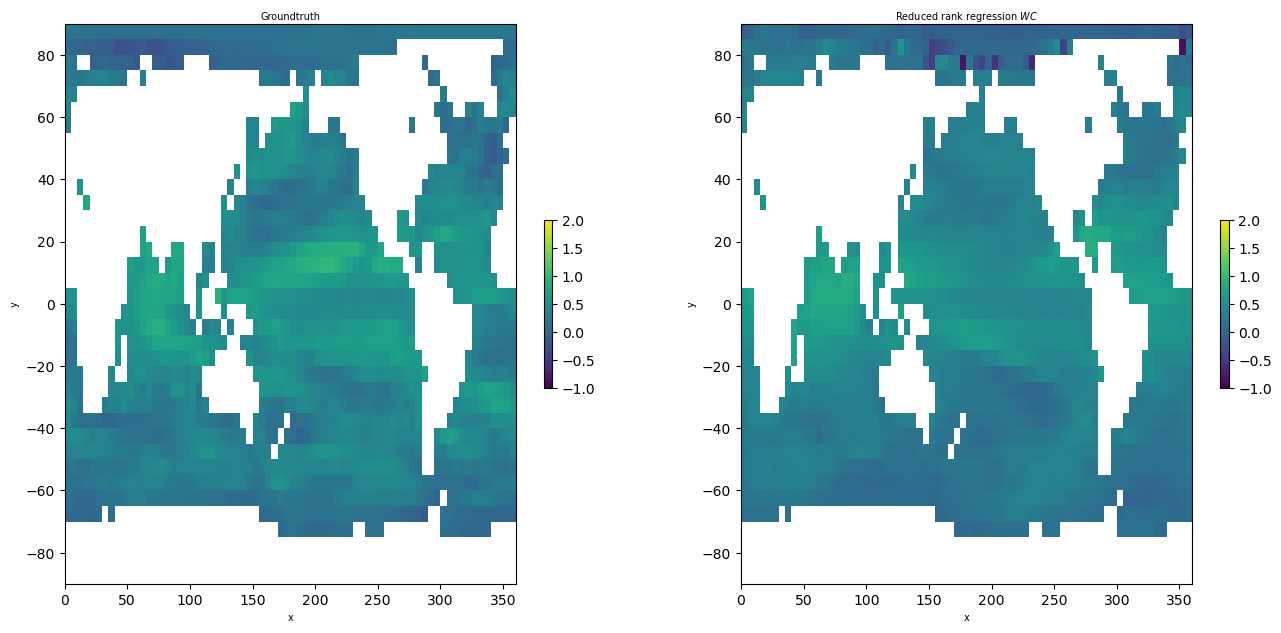

In [18]:
y_pred = torch.ones_like(x_test).to(torch.float64)
y_pred[:,nan_idx] = float('nan')
y_pred[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W_rrr.to(torch.float64)

y_target = y_test[:33,:]
y_target_pred = y_pred[:33,:]


# display Y map for a given model m0
time_idx = 20
y_target[:,nan_idx] = float('nan')
y_target_pred[:,nan_idx] = float('nan')

y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[time_idx,:].detach().numpy().reshape(lat_size,lon_size)


plt.close('all')
fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 2, 2)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

plt.show()

In [19]:
torch.nanmean((y_target - y_target_pred)**2)

tensor(0.0864, dtype=torch.float64)

## display the predicted observations using gif animation 

In [20]:
from matplotlib import animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()


plt.close('all')
fig0 = plt.figure(figsize=(12,12))

ax0 = fig0.add_subplot(1, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(1, 2, 2)        
ax1.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

y_to_plot_target = y_target[0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[0,:].detach().numpy().reshape(lat_size,lon_size)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)


def animate_maps(i):

    y_to_plot_target = y_target[i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred = y_target_pred[i,:].detach().numpy().reshape(lat_size,lon_size)

    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
    im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
    
plt.colorbar(im0, ax=ax0, shrink=0.3)
plt.colorbar(im1, ax=ax1, shrink=0.3)
animation.FuncAnimation(fig0, animate_maps, frames=time_period)

In [21]:
##### TO DO

# - try to use different regularization
# - group lasso regularization? why will it be useful for us?


In [65]:
a = torch.rand(10,10)
print(a)
u = torch.tensor([1,2,4])
torch.index_select(a, (0,1), u)

tensor([[0.8871, 0.0969, 0.9326, 0.0953, 0.3649, 0.7432, 0.2449, 0.0779, 0.3154,
         0.3263],
        [0.4358, 0.2650, 0.8430, 0.3004, 0.3126, 0.3571, 0.8720, 0.0880, 0.0016,
         0.7460],
        [0.0766, 0.5023, 0.3968, 0.6513, 0.9636, 0.4169, 0.9402, 0.5737, 0.3955,
         0.9568],
        [0.2644, 0.8675, 0.0656, 0.4724, 0.6216, 0.1759, 0.3358, 0.6020, 0.6404,
         0.6504],
        [0.6658, 0.8195, 0.6200, 0.8798, 0.0553, 0.9230, 0.5240, 0.3249, 0.4485,
         0.2887],
        [0.7133, 0.1125, 0.3629, 0.3595, 0.7376, 0.4814, 0.5285, 0.6871, 0.1241,
         0.3389],
        [0.4149, 0.7112, 0.8384, 0.9498, 0.9143, 0.1067, 0.0095, 0.4441, 0.4477,
         0.6734],
        [0.3666, 0.6231, 0.5015, 0.2730, 0.3631, 0.7907, 0.9933, 0.2253, 0.6575,
         0.8922],
        [0.8705, 0.6764, 0.8148, 0.9040, 0.0946, 0.2552, 0.8446, 0.2081, 0.1575,
         0.0891],
        [0.1763, 0.9183, 0.0342, 0.6813, 0.9957, 0.1536, 0.6692, 0.5583, 0.0190,
         0.8585]])


TypeError: index_select() received an invalid combination of arguments - got (Tensor, tuple, Tensor), but expected one of:
 * (Tensor input, int dim, Tensor index, *, Tensor out = None)
 * (Tensor input, name dim, Tensor index, *, Tensor out = None)


In [55]:
print(u[0],u[len(u)-1])

1 3


In [72]:
def compute_gradient(models,x,y,w,mu_,lambda_):
    """This function computes the gradient of ridge log-sum-exp loss with respect to W.

    Args:
        
    Returns:
        - Gradient matrix: torch.tensor d x d
    """
    res = torch.zeros(len(models), w.shape[0], w.shape[0])
    res_sumexp = torch.zeros(len(models))

    
    for idx_m, m in enumerate(models):     
        res[idx_m,notnan_idx,notnan_idx] = torch.exp((1/mu_) * torch.norm(y[m][:,notnan_idx] -x[m][:,notnan_idx] @ w[notnan_idx,:][:,notnan_idx], p='fro')**2) * x[m][:,notnan_idx].T @ (y[m][:,notnan_idx] -x[m][:,notnan_idx] @ w[notnan_idx,:][:,notnan_idx]) 
        res_sumexp[idx_m] = torch.exp((1/mu_) * torch.norm(y[m][:,notnan_idx] -x[m][:,notnan_idx] @ w[notnan_idx,:][:,notnan_idx], p='fro')**2)
            
    grad = -2*res/torch.sum(res_sumexp) + 2*lambda_* w

    return grad 

# Define Robust reduced rank regression

# $\max_{\alpha \in \Delta} \min_{W} \sum_{m} \alpha_m \Vert \Sigma^{-1/2}(Y_m - X_m W) \Vert_F^2 + \lambda \Vert W \Vert_F^2$

In [75]:
def train_robust_model(x,y,lon_size,lat_size,models,lambda_=1.0,mu_=1.0,nbEpochs=100,verbose=True):
    """
    Learn parameter β such that β = argmin( log Σ_m exp(||y_m - X_m^T β||^2) ).

    Args:
        - x,y : location, observation 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - models: (sub)list of models (list)
        - mu_: softmax coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    W = torch.ones(lon_size*lat_size,lon_size*lat_size).to(torch.float64)
    W.requires_grad_(True)  

    # define optimizer
    optimizer = torch.optim.Adam([W],lr=1e-3)

    # stopping criterion
    criteria = torch.tensor(0.0)
    criteria_tmp = torch.tensor(1.0) 
    epoch = 0
    training_loss = torch.zeros(nbEpochs)

    grad = compute_gradient(models,x,y,W,mu_,lambda_)
    print(grad)
    print(grad.shape)
    print(torch.sum(torch.isnan(grad)))
            
    # # --- optimization loop ---                
    # while (torch.abs(criteria - criteria_tmp) >= 1e-6) & (epoch < nbEpochs):
    # # while (epoch < nbEpochs):

    #     # update criteria
    #     criteria_tmp = criteria.clone()
                      
    #     optimizer.zero_grad()
    #     ############### Define loss function ##############
    #     res = torch.zeros(len(models))

    #     for idx_m, m in enumerate(models):     
    #         res[idx_m] = torch.sum((y[m][:,notnan_idx] -x[m][:,notnan_idx] @ W[notnan_idx,:][:,notnan_idx] )**2)
            
    #     obj = mu_*torch.logsumexp((1/mu_)* res,0)
    #     obj += lambda_*torch.norm(W,p='nuc')
                    
    #     #define loss function
    #     loss = obj

    #     # set the training loss
    #     training_loss[epoch] = loss.detach().item()
                    
    #     # Use autograd to compute the backward pass. 
    #     loss.backward()               
        
    #     # take a step into optimal direction of parameters minimizing loss
    #     optimizer.step() 

        

    #     if(verbose==True):
    #         if(epoch % 2 == 0):
    #             print('Epoch ', epoch, 
    #                     ', loss=', training_loss[epoch].detach().item()
    #                     )
    #     criteria = loss
    #     epoch +=1
    
    # plt.figure()
    # plt.plot(range(nbEpochs),training_loss)
    # plt.title('Training loss')
    # plt.ylabel('Loss')
    # plt.xlabel('iterations')
    # plt.show()


    ############ HERE ####################
    # # compute the alphas of the robust model
    # M = len(x.keys())
    # alpha = torch.zeros(M)
    # res = torch.zeros(M,33)
    
    # # compute the training loss for each model
    # model_loss = torch.zeros(M)
    
    # for idx_m,m in enumerate(x.keys()):
    #     for idx_i, i in enumerate(x[m].keys()):
    #         res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i],beta))**2/vars[m]
            
    #     res[idx_m,:] = res[idx_m,:]/len(x[m].keys())
    #     alpha[idx_m] = (1/mu_)*torch.mean(res[idx_m,:],axis=0)
    #     model_loss[idx_m] = torch.mean(res[idx_m,:])
    
    # alpha = torch.nn.functional.softmax(alpha)
    
    return W

In [76]:
W = train_robust_model(x_train,y_train,lon_size,lat_size,training_models,lambda_=100.0,mu_=0.1,nbEpochs=500,verbose=True)

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]

In [77]:
19*2592*2592

127650816

In [23]:
plt.close('all')
W = train_robust_model(x_train,y_train,lon_size,lat_size,training_models,lambda_=100.0,mu_=0.1,nbEpochs=500,verbose=True)

Epoch  0 , loss= 69338.3046875
Epoch  2 , loss= 81530.6796875
Epoch  4 , loss= 57595.796875
Epoch  6 , loss= 41647.1328125
Epoch  8 , loss= 47766.28125
Epoch  10 , loss= 35916.578125
Epoch  12 , loss= 38182.01953125
Epoch  14 , loss= 30295.552734375
Epoch  16 , loss= 30252.486328125
Epoch  18 , loss= 27219.537109375
Epoch  20 , loss= 28664.7734375
Epoch  22 , loss= 28434.982421875
Epoch  24 , loss= 24285.248046875
Epoch  26 , loss= 24408.609375
Epoch  28 , loss= 23935.21484375
Epoch  30 , loss= 22258.16015625
Epoch  32 , loss= 22508.638671875
Epoch  34 , loss= 21791.71875
Epoch  36 , loss= 22005.80859375
Epoch  38 , loss= 21020.470703125
Epoch  40 , loss= 20887.453125
Epoch  42 , loss= 21516.28125
Epoch  44 , loss= 20981.435546875
Epoch  46 , loss= 20053.611328125
Epoch  48 , loss= 20384.25
Epoch  50 , loss= 20386.181640625
Epoch  52 , loss= 20651.517578125
Epoch  54 , loss= 19860.23046875
Epoch  56 , loss= 19939.126953125
Epoch  58 , loss= 19814.2109375
Epoch  60 , loss= 20657.8027343


KeyboardInterrupt



In [24]:
y_pred = torch.ones_like(x_test).to(torch.float64)
y_pred[:,nan_idx] = float('nan')
y_pred[:,notnan_idx] = x_test[:,notnan_idx].to(torch.float64) @ W[notnan_idx,:][:,notnan_idx].to(torch.float64)

y_target = y_test[:time_period,:]
y_target_pred = y_pred[:time_period,:]


# display Y map for a given model m0
time_idx = 20
y_target[:,nan_idx] = float('nan')
y_target_pred[:,nan_idx] = float('nan')

y_to_plot_target = y_target[time_idx,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[time_idx,:].detach().numpy().reshape(lat_size,lon_size)


plt.close('all')
fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(2, 2, 2)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

plt.show()

NameError: name 'W' is not defined

In [ ]:
torch.nanmean((y_target - y_target_pred)**2)

In [ ]:
from matplotlib import animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()


plt.close('all')
fig0 = plt.figure()

ax0 = fig0.add_subplot(1, 2, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(1, 2, 2)        
ax1.set_title(r'Robust reduced rank regression ', size=7,pad=3.0)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

y_to_plot_target = y_target[0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred = y_target_pred[0,:].detach().numpy().reshape(lat_size,lon_size)
im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)


def animate_maps(i):

    y_to_plot_target = y_target[i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred = y_target_pred[i,:].detach().numpy().reshape(lat_size,lon_size)

    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=-1.0,vmax=2.0)
    im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred,vmin=-1.0,vmax=2.0)
    
plt.colorbar(im0, ax=ax0, shrink=0.3)
plt.colorbar(im1, ax=ax1, shrink=0.3)
plt.tight_layout()
animation.FuncAnimation(fig0, animate_maps, frames=time_period)